# Задание
- Применить метод К ближащих соседей (ядерный) с алгоритмом STOLP для 5 классов сгенерированных с помошью make_classification
- Для сгенерированного датасета построить профиль компактности
- Для сгенерированного датасета произвести оптимизацию выбора ширены окна
- Найти сет с картинками, метод/библиотеку построения эмбединга картинок (векторизация), применить KNN для векторизованных картинок
- *На своих фотках проверить обученный KNN

In [1]:
import os
# import timm
import math
import random
import copy
# import optuna

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [2]:
Сoordinates, Lable = make_classification(n_samples=1200, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=20)

Сoordinates_train, Сoordinates_test, Lable_train, Lable_test = train_test_split(Сoordinates, Lable, 
                                                    test_size=400, 
                                                    random_state=0)


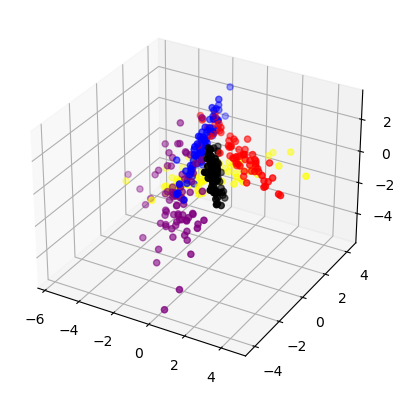

In [3]:
N = 400
colors = ["Blue","Red","Purple","Yellow","Black"]
c = [colors[i] for i in Lable_train[:N]]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Сoordinates_train[:N,0], Сoordinates_train[:N,1], Сoordinates_train[:N,2], c=c)
plt.show()

In [4]:
def Logist(r,h=1): # логистическое ядро
    r=np.array(r)/h
    return (1/(2+np.exp(r)+np.exp(-r)))

In [5]:
knn=KNeighborsRegressor(n_neighbors=6,weights=Logist)
knn.fit(Сoordinates_train, Lable_train)
knn.score(Сoordinates_test, Lable_test)

0.8513394384870647

## Stolp
 Вход

    Выборка X^l
    Допустимая доля ошибок l_0
    Порог отсечения выбросов δ
    Алгоритм классификации
    Формула для вычисления величины риска W. 

Описание алгоритма

    Отбросить выбросы (объекты X^l с W>δ)
    Сформировать начальное приближение \Omega — из объектов выборки X^l выбрать по одному объекту каждого класса, обладающему среди объектов данного класса максимальной величиной риска[1] либо минимальной величиной риска[1]
    Наращивание множества эталонов (пока число объектов выборки X^l, распознаваемых неправильно, не станет меньше l_0):
        Классифицировать объекты X^l, используя в качестве обучающей выборки \Omega
        Пересчитать величины риска для всех объектов X^l \setminus \Omega с учетом изменения обучающей выборки
        Среди объектов каждого класса, распознанных неправильно, выбрать объекты с максимальной величиной риска и добавить их к \Omega 


##    Формула для вычисления величины риска W.

In [6]:
def WOkn(kor,X,Y,Y_learn,Logist=Logist):
    neigh_dist, neigh_ind = kor.kneighbors([X])
    dist=Logist(neigh_dist)
    lable=[Y_learn[i] for i in neigh_ind[0]]
    klass_weigh=np.zeros(max(lable)+1)
    for i in range(len(lable)):
        klass_weigh[lable[i]]+=dist[0][i]
    MG=0
    M=0
    for i in range(len(klass_weigh)):
        if i == Y:
            M=klass_weigh[i]
        elif klass_weigh[i]>MG:
            MG=klass_weigh[i]
    M=M-MG
    return -M

In [7]:
def Stopl(X_train,Y_train,k,lo,sigm=0.8,alg_clas=KNeighborsRegressor,W=WOkn):
    knn=alg_clas(n_neighbors=k,weights=Logist)
    knn.fit(X_train, Y_train)
    X_noise=None
    Y_noise=None
    ind_Deleat=np.array(1)
    X_etalon=np.zeros(((max(Y_train)+1), 3))
    clas_min_Risk=np.array([sigm for i in range(len(X_etalon))])  
    X_isp=copy.deepcopy(X_train)
    Y_isp=copy.deepcopy(Y_train)
    for i in range(len(X_train)):
        Wi=W(knn,X_train[i],Y_train[i],Y_train)
        if Wi<=sigm:
            if clas_min_Risk[Y_train[i]] > Wi:
                X_etalon[Y_train[i]]=X_train[i]
                clas_min_Risk[Y_train[i]]=Wi
        else:
            ind_Deleat=np.append(ind_Deleat,i)
            # print(ind_Deleat)
            if X_noise is None:
                X_noise=[X_train[i]]
                Y_noise=[Y_train[i]]
            else:
                X_noise=np.append(X_noise,[X_train[i]],axis=0)
                Y_noise=np.append(Y_noise,[Y_train[i]],axis=0)
    X_isp=np.delete(X_isp,(ind_Deleat.astype(int)), axis = 0)
    Y_isp=np.delete(Y_isp,(ind_Deleat.astype(int)), axis = 0)
    # удаляем из X_isp эталоны
    for  i in range(len(X_etalon)):
        Y_isp = Y_isp[np.min(X_isp[:] != X_etalon[i],axis=1)]
        X_isp = X_isp[np.min(X_isp[:] != X_etalon[i],axis=1)]
    Y_etalon=np.array([i for i in range(len(X_etalon))])
    while 1:
        if len(X_etalon)<k:
            knn=KNeighborsRegressor(n_neighbors=len(X_etalon),weights=Logist)
        else:
            knn=KNeighborsRegressor(n_neighbors=k,weights=Logist)
        knn.fit(X_etalon, Y_etalon)
        # print(knn.score(X_isp,Y_isp))
        if 1-knn.score(X_isp,Y_isp)<lo:
            break
        X_Plusetalon=np.zeros(((max(Y_train)+1), 3))
        clas_max_Risk=np.array([None for i in range(len(clas_min_Risk))]) 
        for i in range(len(X_isp)):
            Wi=W(knn,X_isp[i],Y_isp[i],Y_train)
            if knn.predict(np.array([X_isp[i]])) !=Y_isp[i]:
                if clas_max_Risk[Y_isp[i]] is None or clas_min_Risk[Y_isp[i]]<Wi:
                    clas_min_Risk[Y_isp[i]]=Wi
                    X_Plusetalon[Y_isp[i]]=X_isp[i]
        Y_Plusetalon=np.array([i for i in range(len(X_Plusetalon))])
        X_etalon=np.append(X_etalon,X_Plusetalon,axis=0)
        Y_etalon=np.append(Y_etalon,Y_Plusetalon)
        for i in range(len(X_Plusetalon)):
            Y_isp = Y_isp[np.min(X_isp[:] != X_Plusetalon[i],axis=1)]
            X_isp = X_isp[np.min(X_isp[:] != X_Plusetalon[i],axis=1)]
                
            
    return X_etalon ,Y_etalon ,X_isp,Y_isp,X_noise, Y_noise

In [8]:
X_etalon ,Y_etalon ,X_isp,Y_isp,X_noise, Y_noise=Stopl(Сoordinates_train,Lable_train,6,lo=0.1,sigm=0)
print(len(X_etalon),len(X_isp),len(X_noise),len(X_etalon)==len(Y_etalon),len(X_isp)==len(Y_isp),len(X_noise)==len(Y_noise))

225 523 55 True True True


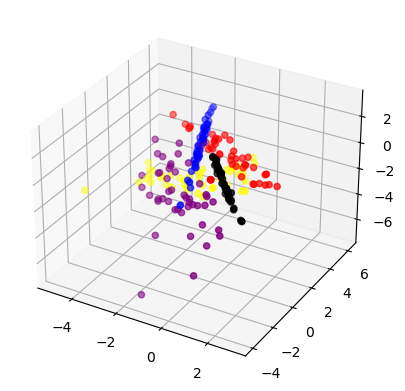

In [9]:
N = len(X_etalon)
colors = ["Blue","Red","Purple","Yellow","Black"]
c = [colors[i] for i in Y_etalon[:N]]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_etalon[:N,0], X_etalon[:N,1], X_etalon[:N,2], c=c)
plt.show()

In [11]:
knn=KNeighborsRegressor(n_neighbors=6,weights=Logist)
knn.fit(X_etalon, Y_etalon)
knn.score(Сoordinates_test, Lable_test)

0.7729996339058166

# Оптимизация параметров k, lo, sigma

In [14]:
results = [] # we will store our results here.
for k in range(1, 8): # maximum neighbor is 9 since 9:1 train split
    for sigm in range(-2,6):
        sigm/=10
        for lo in range(1,100,10):
            lo/=100

        
            temp_mae = [] # temporary storage for mean absolute error
            
            # Set kernel_width = w

            
            # We take average of ten bootstrapped model.
            for i in range(0,5):
                # Below is my personal way of setting random state. This makes each run a bootstrapped model.

                X_train, X_test, y_train, y_test = train_test_split(Сoordinates,
                                                                    Lable,
                                                                    test_size=0.1,
                                                                    random_state=int(100*np.random.random()))
                X_etalon ,Y_etalon ,_,_,_,_=Stopl(Сoordinates_train,Lable_train,k,lo=lo,sigm=sigm)
                knn = KNeighborsRegressor(n_neighbors=k,weights=Logist)
                knn.fit(X_etalon, Y_etalon)
                y_pred = knn.predict(X_test)
                mean_absolute_error = np.mean(abs(y_pred-y_test))
                temp_mae.append(mean_absolute_error)
            average_over_ten_runs = np.mean(temp_mae)
            results.append([k, lo,sigm, average_over_ten_runs]) # We store our run result.
        print("sigm",sigm)    
    print("k",k)
        

results

sigm -0.2


In [ ]:
# For easier access of columns, convert to numpy array 
results = np.array(results)
# Now we visualize.
plt.scatter(results[:,0],results[:,1],c=results[:,3],cmap='cool',s=results[:,2])
plt.xlabel('n_neighbors', fontsize=14)
plt.ylabel('kernel_width', fontsize=14)
plt.title('Error Values for Hyperparameters', fontsize=14)
plt.colorbar().set_label('Mean Absolute Error')
#plt.clim(3, 4.0)

### Профиль компактности на всем train

Профиль компактности на всем train


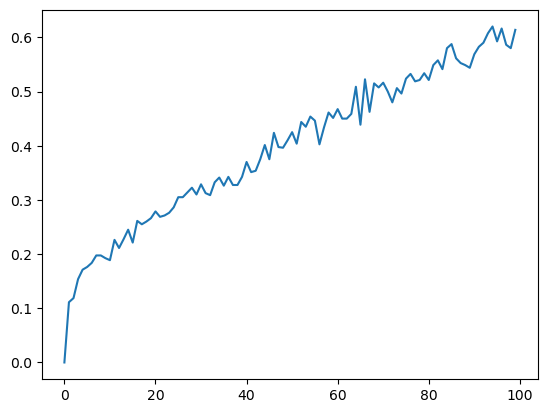

In [13]:
N = 100
R = []
for j in range(N):
    R_j = 0
    for x_i, y_i in zip(Сoordinates_train, Lable_train):
        dtype = [('y', int), ('distance', float)]
        ind = np.arange(len(Lable_train))
        data = [(y, math.dist(x_i,x)) for x, y in zip(Сoordinates_train, Lable_train)]
        data = np.array(data, dtype=dtype)
        data = np.sort(data, order=['distance'])
        R_j += data[j]['y'] != y_i
    R.append(R_j / len(Lable_train))

plt.plot(range(100), R)
plt.show()

### Профиль компактности на эталонных обьектах

In [ ]:
N = 100
R = []
for j in range(N):
    R_j = 0
    for x_i, y_i in zip( X_etalon, Y_etalon):
        dtype = [('y', int), ('distance', float)]
        ind = np.arange(len(Y_etalon))
        data = [(y, math.dist(x_i,x)) for x, y in zip(X_etalon, Y_etalon)]
        data = np.array(data, dtype=dtype)
        data = np.sort(data, order=['distance'])
        R_j += data[j]['y'] != y_i
    R.append(R_j / len(Y_etalon))

plt.plot(range(100), R)
plt.show()

## Оптимеация выбора ширены окна

In [ ]:
import optuna

def objective(trial):
    h = trial.suggest_float("h", 0.01, 100, log=True)
    model = KNeighborsClassifier(n_neighbors=len(Сoordinates_train),
                                 weights=lambda x: Logist(x, h=h)) # обучение с коэфициентом h
    model.fit(Сoordinates_train, Lable_train)
    return 1 / model.score(Сoordinates_test, Lable_test, sample_weight=None)

optuna.logging.disable_default_handler() #Отключить логирование
study = optuna.create_study()
study.optimize(objective, n_trials=400)

best_params = study.best_params
found_h_opt = best_params["h"]
model = KNeighborsClassifier(n_neighbors=len(Сoordinates_train),
                                 weights=lambda x: K(x, h=found_h_opt)) # обучение с коэфициентом h
model.fit(Сoordinates_train, Lable_train)
print("Найденная ширина окна h: {:0.3f}, Точность при данной ширине окна: {:0.3f}".format(found_h_opt, model.score(Сoordinates_test, Lable_test, sample_weight=None)))